In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import math

In [33]:
df = pd.read_csv('../../Resource/address_dataset_kaggle.csv', index_col=0)

# 2. Data Cleaning
columns_drop = ['Index', 'Address']  
df = df.drop(columns=columns_drop)

In [34]:
# Imputasi untuk kolom numerik (mean)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_imputer = SimpleImputer(strategy='mean')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Imputasi untuk kolom kategorikal (modus)
cat_cols = df.select_dtypes(include=['object']).columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [35]:
X = df.drop(columns=['FLAG'])
y = df['FLAG']

In [36]:
hasher = FeatureHasher(n_features=10, input_type='string')  # Adjust n_features as needed
cat_cols_in_X = X.select_dtypes(include=['object']).columns

for col in cat_cols_in_X:
    data_to_hash = X[col].astype(str).values.reshape(-1, 1)
    hashed_features = hasher.transform(data_to_hash).toarray()
    hashed_df = pd.DataFrame(hashed_features, columns=[f"{col}_hashed_{i}" for i in range(hashed_features.shape[1])])
    X = pd.concat([X, hashed_df], axis=1)
    X.drop(columns=[col], inplace=True)

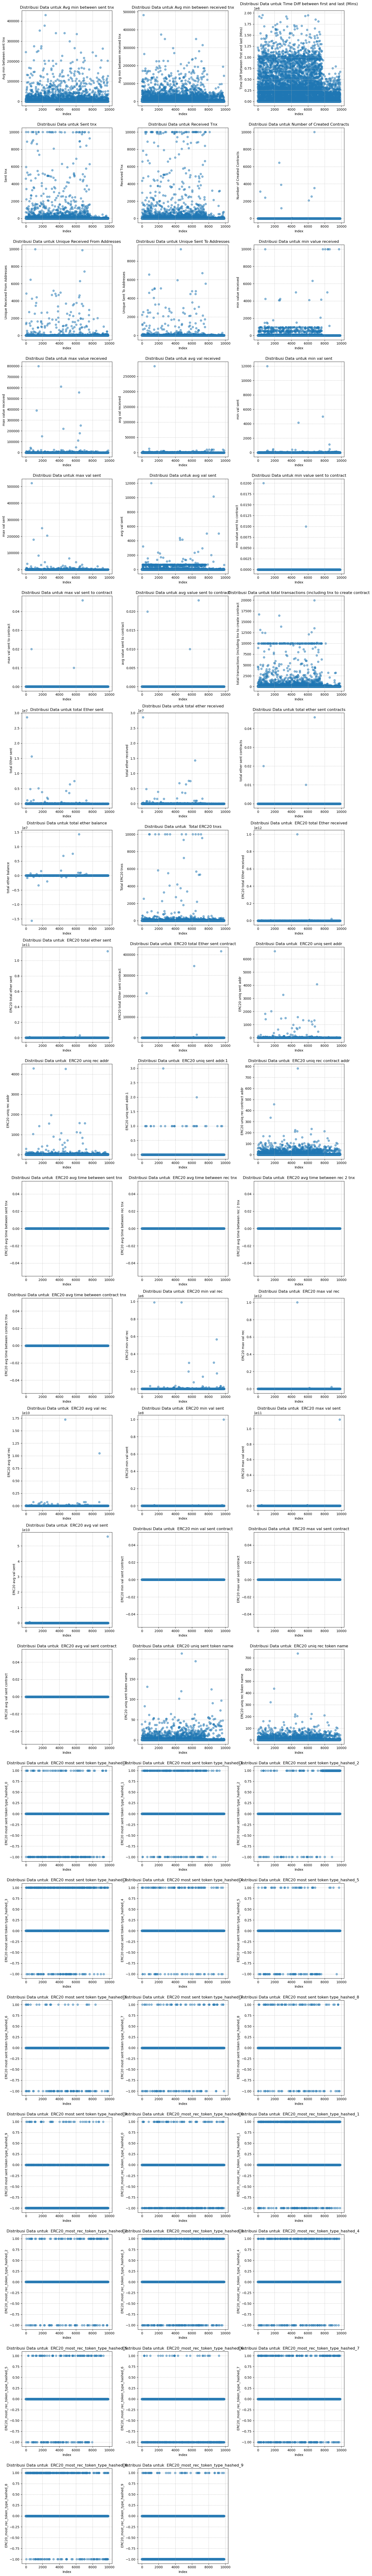

In [37]:
# Visualisasi distribusi fitur numerik
num_cols_in_X = X.select_dtypes(include=['float64', 'int64']).columns
n_plots = len(num_cols_in_X)
n_rows = math.ceil(n_plots / 3)

plt.figure(figsize=(15, 5 * n_rows))
for idx, col in enumerate(num_cols_in_X, 1):
    plt.subplot(n_rows, 3, idx)
    plt.scatter(range(len(X)), X[col], alpha=0.5)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(f'Distribusi Data untuk {col}')
    plt.xlabel('Index')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [38]:
# 4. Log-transformasi untuk fitur numerik
X_safe = X.copy()
X_safe[num_cols_in_X] = X_safe[num_cols_in_X].apply(lambda col: col.apply(lambda x: x if x > 0 else 0.001))

log_transformer = FunctionTransformer(np.log1p, validate=True)
X_log = log_transformer.fit_transform(X_safe[num_cols_in_X])
X_log = pd.DataFrame(X_log, columns=num_cols_in_X)

# Gabungkan hasil transformasi ke DataFrame X
X[num_cols_in_X] = X_log

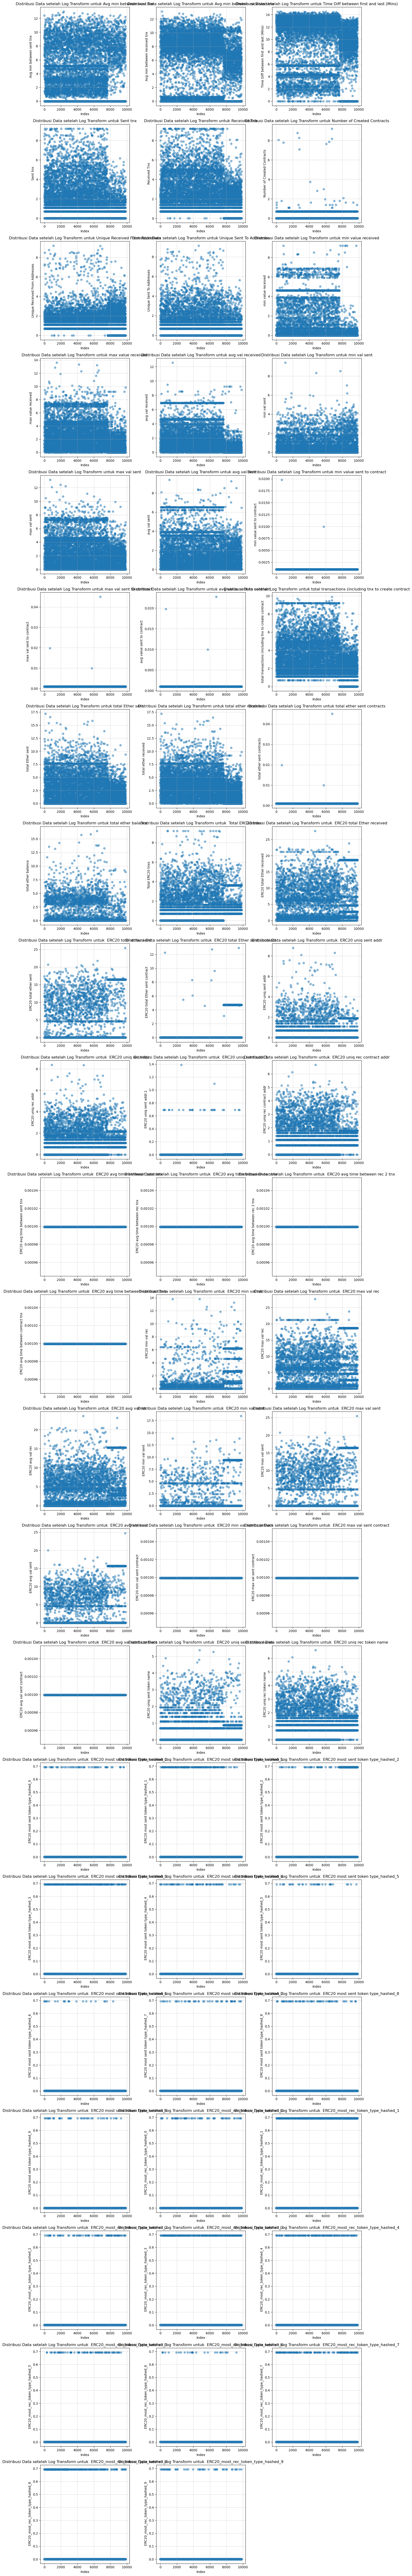

In [39]:
plt.figure(figsize=(15, 5 * n_rows))
for idx, col in enumerate(num_cols_in_X, 1):
    plt.subplot(n_rows, 3, idx)
    plt.scatter(range(len(X_log)), X_log[col], alpha=0.5)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(f'Distribusi Data setelah Log Transform untuk {col}')
    plt.xlabel('Index')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [40]:
model = RandomForestClassifier(random_state=42)  # Gunakan model berbasis estimasi
rfe = RFE(estimator=model, n_features_to_select=30)  # Sesuaikan jumlah fitur yang diinginkan
rfe.fit(X, y)

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=30)

In [41]:
# Hasil seleksi fitur
selected_features = X.columns[rfe.support_]
feature_importance = rfe.estimator_.feature_importances_  # Importance dari fitur yang dipilih

# Menampilkan fitur yang dipilih beserta pentingnya
print("Fitur yang dipilih berdasarkan RFE:")
for feature, importance in zip(selected_features, feature_importance):
    print(f"Fitur: {feature}, Pentingnya: {importance:.4f}")

Fitur yang dipilih berdasarkan RFE:
Fitur: Avg min between received tnx, Pentingnya: 0.0208
Fitur: Time Diff between first and last (Mins), Pentingnya: 0.0410
Fitur: Sent tnx, Pentingnya: 0.0073
Fitur: Received Tnx, Pentingnya: 0.0111
Fitur: Unique Received From Addresses, Pentingnya: 0.0204
Fitur: max value received , Pentingnya: 0.0107
Fitur: avg val received, Pentingnya: 0.0116
Fitur: min val sent, Pentingnya: 0.0097
Fitur: total transactions (including tnx to create contract, Pentingnya: 0.0226
Fitur: total Ether sent, Pentingnya: 0.0054
Fitur: total ether received, Pentingnya: 0.0172
Fitur: total ether balance, Pentingnya: 0.0059
Fitur:  Total ERC20 tnxs, Pentingnya: 0.0291
Fitur:  ERC20 total Ether received, Pentingnya: 0.0520
Fitur:  ERC20 total ether sent, Pentingnya: 0.0237
Fitur:  ERC20 total Ether sent contract, Pentingnya: 0.0531
Fitur:  ERC20 uniq sent addr, Pentingnya: 0.0107
Fitur:  ERC20 uniq rec addr, Pentingnya: 0.0129
Fitur:  ERC20 uniq sent addr.1, Pentingnya: 0.039

In [42]:
X_selected = X[selected_features]
X_selected.columns

Index(['Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Unique Received From Addresses', 'max value received ',
       'avg val received', 'min val sent',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received', 'total ether balance',
       ' Total ERC20 tnxs', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr',
       ' ERC20 min val rec', ' ERC20 max val rec', ' ERC20 avg val rec',
       ' ERC20 min val sent', ' ERC20 max val sent', ' ERC20 avg val sent',
       ' ERC20 uniq sent token name', ' ERC20 uniq rec token name',
       ' ERC20 most sent token type_hashed_2',
       ' ERC20_most_rec_token_type_hashed_1'],
      dtype='object')

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [44]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [45]:
print(X_train_smote.shape)
print(y_train_smote.shape)
print(X_test.shape)
print(y_test.shape)

(12240, 30)
(12240,)
(1969, 30)
(1969,)


In [46]:
X_train_smote.to_csv("../../Data/recursive/n=30/X_train_smote.csv", index=False)
X_test.to_csv("../../Data/recursive/n=30/X_test.csv", index=False)
y_train_smote.to_csv("../../Data/recursive/n=30/y_train_smote.csv", index=False)
y_test.to_csv("../../Data/recursive/n=30/y_test.csv", index=False)

print("Proses selesai. Data oversampling dan fitur yang dipilih telah disimpan.")

Proses selesai. Data oversampling dan fitur yang dipilih telah disimpan.


In [ ]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.feature_extraction import FeatureHasher
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import RandomForestClassifier
# from imblearn.over_sampling import SMOTE
# import math

# # 1. Memuat data
# df = pd.read_csv('../../Resource/address_dataset_kaggle.csv', index_col=0)

# # 2. Data Cleaning
# columns_drop = ['Index', 'Address']  
# df = df.drop(columns=columns_drop)

# # Imputasi untuk kolom numerik (mean)
# num_cols = df.select_dtypes(include=['float64', 'int64']).columns
# num_imputer = SimpleImputer(strategy='mean')
# df[num_cols] = num_imputer.fit_transform(df[num_cols])

# # Imputasi untuk kolom kategorikal (modus)
# cat_cols = df.select_dtypes(include=['object']).columns
# cat_imputer = SimpleImputer(strategy='most_frequent')
# df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# # 3. Preprocessing
# X = df.drop(columns=['FLAG'])
# y = df['FLAG']

# # Hashing fitur kategorikal
# hasher = FeatureHasher(n_features=20, input_type='string')  # Adjust n_features as needed
# cat_cols_in_X = X.select_dtypes(include=['object']).columns

# for col in cat_cols_in_X:
#     data_to_hash = X[col].astype(str).values.reshape(-1, 1)
#     hashed_features = hasher.transform(data_to_hash).toarray()
#     hashed_df = pd.DataFrame(hashed_features, columns=[f"{col}_hashed_{i}" for i in range(hashed_features.shape[1])])
#     X = pd.concat([X, hashed_df], axis=1)
#     X.drop(columns=[col], inplace=True)

# # Visualisasi distribusi fitur numerik
# num_cols_in_X = X.select_dtypes(include=['float64', 'int64']).columns
# n_plots = len(num_cols_in_X)
# n_rows = math.ceil(n_plots / 3)

# plt.figure(figsize=(15, 5 * n_rows))
# for idx, col in enumerate(num_cols_in_X, 1):
#     plt.subplot(n_rows, 3, idx)
#     plt.scatter(range(len(X)), X[col], alpha=0.5)
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.title(f'Distribusi Data untuk {col}')
#     plt.xlabel('Index')
#     plt.ylabel(col)
# plt.tight_layout()
# plt.show()

# # 4. Log-transformasi untuk fitur numerik
# X_safe = X.copy()
# X_safe[num_cols_in_X] = X_safe[num_cols_in_X].apply(lambda col: col.apply(lambda x: x if x > 0 else 0.001))

# log_transformer = FunctionTransformer(np.log1p, validate=True)
# X_log = log_transformer.fit_transform(X_safe[num_cols_in_X])
# X_log = pd.DataFrame(X_log, columns=num_cols_in_X)

# # Gabungkan hasil transformasi ke DataFrame X
# X[num_cols_in_X] = X_log

# plt.figure(figsize=(15, 5 * n_rows))
# for idx, col in enumerate(num_cols_in_X, 1):
#     plt.subplot(n_rows, 3, idx)
#     plt.scatter(range(len(X_log)), X_log[col], alpha=0.5)
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.title(f'Distribusi Data setelah Log Transform untuk {col}')
#     plt.xlabel('Index')
#     plt.ylabel(col)
# plt.tight_layout()
# plt.show()

# # 5. Recursive Feature Elimination (RFE)
# model = RandomForestClassifier(random_state=42)  # Gunakan model berbasis estimasi
# rfe = RFE(estimator=model, n_features_to_select=10)  # Sesuaikan jumlah fitur yang diinginkan
# rfe.fit(X, y)

# # Hasil seleksi fitur
# selected_features = X.columns[rfe.support_]
# feature_importance = rfe.estimator_.feature_importances_  # Importance dari fitur yang dipilih

# # Menampilkan fitur yang dipilih beserta pentingnya
# print("Fitur yang dipilih berdasarkan RFE:")
# for feature, importance in zip(selected_features, feature_importance):
#     print(f"Fitur: {feature}, Pentingnya: {importance:.4f}")

# # Visualisasi fitur yang dipilih dan pentingnya
# plt.figure(figsize=(12, 6))
# sns.barplot(x=selected_features, y=feature_importance)
# plt.title('Pentingnya Fitur yang Dipilih dengan RFE')
# plt.xlabel('Fitur')
# plt.ylabel('Pentingnya')
# plt.xticks(rotation=90)
# plt.show()

# # 6. Menyimpan data dengan fitur yang dipilih
# X_selected = X[selected_features]

# # 7. Split data menjadi train dan test (80:20)
# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# # 8. Oversampling dengan SMOTE
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# # 9. Simpan data hasil preprocessing
# X_train_smote.to_csv("../../Data/rfe/n=20/100/X_train_smote.csv", index=False)
# X_test.to_csv("../../Data/rfe/n=20/100/X_test.csv", index=False)
# y_train_smote.to_csv("../../Data/rfe/n=20/100/y_train_smote.csv", index=False)
# y_test.to_csv("../../Data/rfe/n=20/100/y_test.csv", index=False)

# print("Proses selesai. Data oversampling dan fitur yang dipilih telah disimpan.")
